#EmDet

Purpose of this project is to build an NLP model to predict the emotion

## Get Data

In [1]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("emotion")

     |████████████████████████████████| 290 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 39.7 MB/s 
     |████████████████████████████████| 125 kB 46.4 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 243 kB 42.6 MB/s 
     |████████████████████████████████| 271 kB 43.0 MB/s 
     |████████████████████████████████| 160 kB 49.5 MB/s 


Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# Check the imported dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Preprocess data

In [3]:
# Split the dataset into training, validation and test datasets
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

In [4]:
print(train_data[0])
print(train_data.column_names)
print(train_data.features)

{'label': 0, 'text': 'i didnt feel humiliated'}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}


In [5]:
# Turn all the datasets into pd.DataFrame's
import pandas as pd
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
# Add a description column
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_df['description'] = train_df['label'].map(labels_dict )
val_df['description'] = val_df['label'].map(labels_dict )
test_df['description'] = test_df['label'].map(labels_dict )
train_df.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [7]:
# Drop the label column
train_df.drop(["label"], axis=1, inplace=True)
val_df.drop(["label"], axis=1, inplace=True)
test_df.drop(["label"], axis=1, inplace=True)
train_df.head()

,text,description
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         16000 non-null  object
 1   description  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [14]:
# Convert abstract text lines into numpy arrays
train_sentences = train_df["text"].to_numpy()
train_labels = train_df["description"].to_numpy()

val_sentences = val_df["text"].to_numpy()
val_labels = val_df["description"].to_numpy()

test_sentences = test_df["text"].to_numpy()
test_labels = test_df["description"].to_numpy()

In [15]:
# View first 10 lines of training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['i didnt feel humiliated',
        'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
        'im grabbing a minute to post i feel greedy wrong',
        'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
        'i am feeling grouchy',
        'ive been feeling a little burdened lately wasnt sure why that was',
        'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
        'i feel as confused about life as a teenager or as jaded as a year old man',
        'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
        'i feel romantic too'], dtype=object),
 array(['sadness', 'sadness', 'anger', 'love', 'anger', 'sadness',
        'surprise', 'fear', 'joy', 'love'], dtype=object))

## Make numeric labels

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels 

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.



### One hot encode labels

In [16]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1,1))

In [17]:
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]]), (16000, 6))

### Label encode labels

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [19]:
val_labels_encoded, val_labels_encoded.shape

(array([4, 4, 3, ..., 2, 2, 2]), (2000,))

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(6, array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object))

## Starting a Series of Modelling Experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

## Model 0: Getting a baseline

Our first model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf_idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.641

In [23]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 4, 2, ..., 2, 2, 2])

### Download helper function script

In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-28 06:33:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-28 06:33:30 (81.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [26]:
from helper_functions import calculate_results

In [27]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 64.1,
 'f1': 0.5476309366603793,
 'precision': 0.7148671181119123,
 'recall': 0.641}

## Preparing the data for deep sequence models

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

19.1663125

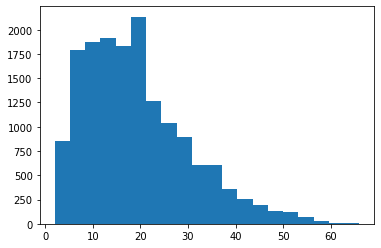

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 40 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

41

It looks like 95% of the sentences in our training set have a length of 41 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 26 get padded with zeros and sentences with a length above 41 get truncated (words after 41 get cut off).

## Create text vectorizer layer

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [32]:
# How many words are in our vocab?
from collections import Counter
results = Counter()
train_df["text"].str.lower().str.split().apply(results.update)
len(results)

15212

In [33]:
max_tokens = 15200

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"Length of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
i feel isolated as a stay at home mum shonas story notes d athe only negative for me is that i feel isolated as a stay at home mum
Length of text: 29

Vectorized text:
[[    2     3   549    29     7   569    33   167  1644  8999   432  2875
    677 14798   118  1076    16    18    22     8     2     3   549    29
      7   569    33   167  1644     0     0     0     0     0     0     0
      0     0     0     0     0]]


Using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) method of our `text_vectorizer` we can find out a few different tidbits about our text.

In [37]:
# How many words in our training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 15200
Most common words in vocab: ['', '[UNK]', 'i', 'feel', 'and']
Least common words in vocab: ['abou', 'abortion', 'abominable', 'aboard', 'abnormally']


In [38]:
# Get the config of our text_vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 15200,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 41,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

## Create custom text embedding

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [39]:
# Create custom text embedding
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentece after vectorization (before the embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentece after embedding: {embedded_sentence}\n")
print(f"Embedded sentece shape: {embedded_sentence.shape}")

Sentence before vectorization:
i feel isolated as a stay at home mum shonas story notes d athe only negative for me is that i feel isolated as a stay at home mum

Sentece after vectorization (before the embedding):
[[    2     3   549    29     7   569    33   167  1644  8999   432  2875
    677 14798   118  1076    16    18    22     8     2     3   549    29
      7   569    33   167  1644     0     0     0     0     0     0     0
      0     0     0     0     0]]

Sentece after embedding: [[[-0.042512   -0.04288453 -0.00062543 ... -0.03051841  0.01582943
    0.01839948]
  [-0.02086822 -0.00438213 -0.03495789 ...  0.01782827  0.04019061
   -0.01205304]
  [ 0.01833311 -0.02008654  0.01299338 ...  0.03616147  0.04742606
   -0.01451695]
  ...
  [ 0.0203278   0.03633427 -0.00100058 ... -0.02214106 -0.01313484
   -0.00681115]
  [ 0.0203278   0.03633427 -0.00100058 ... -0.02214106 -0.01313484
   -0.00681115]
  [ 0.0203278   0.03633427 -0.00100058 ... -0.02214106 -0.01313484
   -0.00681115]

## Creating datasets (making sure our data loads as fast as possible)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (6,)), types: (tf.string, tf.float64)>

In [42]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(24, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.MaxPooling1D(pool_size=2, padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)  #condense the output of our vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [44]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [45]:
# Get a summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 41)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 41, 128)           1945600   
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 24)            15384     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 24)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 150   

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter of the `Embedding` layer), the number of trainable parameters would increase dramatically.

In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 36s 12ms/step - loss: 1.2684 - accuracy: 0.5437 - val_loss: 0.6140 - val_accuracy: 0.8355
Epoch 2/5
500/500 [==============================] - 6s 11ms/step - loss: 0.3668 - accuracy: 0.8910 - val_loss: 0.3865 - val_accuracy: 0.8670
Epoch 3/5
500/500 [==============================] - 6s 11ms/step - loss: 0.1766 - accuracy: 0.9480 - val_loss: 0.3674 - val_accuracy: 0.8910
Epoch 4/5
500/500 [==============================] - 6s 11ms/step - loss: 0.0985 - accuracy: 0.9727 - val_loss: 0.3987 - val_accuracy: 0.8825
Epoch 5/5
500/500 [==============================] - 6s 11ms/step - loss: 0.0634 - accuracy: 0.9826 - val_loss: 0.4475 - val_accuracy: 0.8715


In [53]:
# Evaluate the model on test_dataset
model_1.evaluate(test_dataset)

63/63 [==============================] - 0s 6ms/step - loss: 0.4703 - accuracy: 0.8625


[0.47026216983795166, 0.862500011920929]

In [50]:
# Make predictions
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs

array([[2.7204026e-04, 2.6634254e-03, 1.0242800e-03, 1.1948563e-04,
        9.9577647e-01, 1.4436092e-04],
       [9.5832016e-04, 1.8835976e-03, 7.0347864e-04, 2.8698010e-05,
        9.9627256e-01, 1.5333532e-04],
       [1.8174996e-03, 2.6357989e-03, 1.4055355e-02, 3.8882354e-04,
        9.8081124e-01, 2.9125344e-04],
       ...,
       [1.3961613e-03, 1.5674814e-04, 9.9448365e-01, 3.7461668e-03,
        1.5094633e-04, 6.6394510e-05],
       [2.8876660e-03, 1.5555830e-04, 9.9339479e-01, 7.6899113e-04,
        2.7586785e-03, 3.4324938e-05],
       [1.7232137e-02, 7.1323663e-01, 3.3566026e-05, 4.8754984e-03,
        3.1956422e-04, 2.6430261e-01]], dtype=float32)

In [51]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [52]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 86.25,
 'f1': 0.861475282478082,
 'precision': 0.8661564818044345,
 'recall': 0.8625}

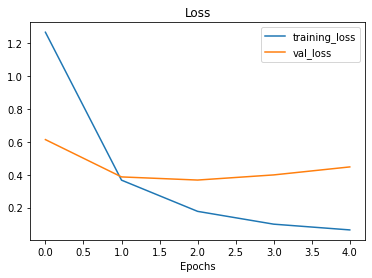

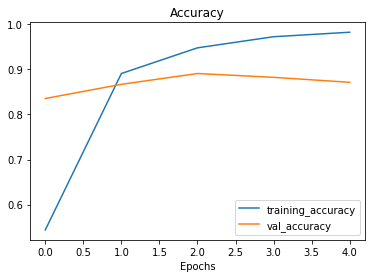

In [49]:
# Plot the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_1)

# Model 2: LSTM

In [54]:
# Create an embedding layer (new embedding layer for each model)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=len(text_vocab),
                                     output_dim=128,
                                     mask_zero=True,
                                     name="embedding_2")
# Create LSTM model 
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
x = layers.LSTM(48)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [55]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 41)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 41, 128)           1945600   
_________________________________________________________________
lstm (LSTM)                  (None, 48)                33984     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 294       
Total params: 1,979,878
Trainable params: 1,979,878
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [57]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 18s 26ms/step - loss: 0.3803 - accuracy: 0.4560 - val_loss: 0.2706 - val_accuracy: 0.6825
Epoch 2/5
500/500 [==============================] - 11s 23ms/step - loss: 0.1555 - accuracy: 0.8308 - val_loss: 0.1229 - val_accuracy: 0.8650
Epoch 3/5
500/500 [==============================] - 11s 23ms/step - loss: 0.0678 - accuracy: 0.9342 - val_loss: 0.0794 - val_accuracy: 0.9125
Epoch 4/5
500/500 [==============================] - 11s 23ms/step - loss: 0.0348 - accuracy: 0.9654 - val_loss: 0.0829 - val_accuracy: 0.9165
Epoch 5/5
500/500 [==============================] - 11s 23ms/step - loss: 0.0217 - accuracy: 0.9809 - val_loss: 0.1034 - val_accuracy: 0.9115


In [62]:
# Evaluate the model on test_data
model_2.evaluate(test_dataset)

63/63 [==============================] - 1s 9ms/step - loss: 0.1138 - accuracy: 0.8940


[0.11384951323270798, 0.8939999938011169]

In [63]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(test_dataset)
model_2_pred_probs

array([[2.8798688e-06, 1.7445162e-06, 1.6318469e-06, 8.1282373e-08,
        9.9999225e-01, 1.3966461e-06],
       [3.0308589e-05, 9.0187896e-06, 2.1736269e-05, 3.5473752e-07,
        9.9993229e-01, 6.3300017e-06],
       [1.1046592e-04, 3.0661911e-05, 1.1344665e-04, 2.3260675e-06,
        9.9968636e-01, 5.6725352e-05],
       ...,
       [3.5200091e-07, 8.7243603e-07, 9.9999273e-01, 5.1710563e-06,
        6.8487827e-07, 2.2896400e-07],
       [2.8713794e-07, 3.4557743e-07, 9.9999607e-01, 2.4693927e-06,
        5.9031163e-07, 2.0693845e-07],
       [1.4337644e-04, 9.9908173e-01, 5.0829281e-06, 2.7717091e-04,
        1.4120981e-05, 4.7848927e-04]], dtype=float32)

In [64]:
# Convert model_2_pred_probs to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [65]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 89.4,
 'f1': 0.8931857282449579,
 'precision': 0.8963034217387778,
 'recall': 0.894}

In [66]:
# Create a helper function to compare our results
def compare_baseline_to_new_results(old_model_results, new_model_results):
  for key, value in old_model_results.items():
    print(f"Old {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [67]:
# Compare model_1's results with model_2's results
compare_baseline_to_new_results(old_model_results=model_1_results, 
                                new_model_results=model_2_results)

Old accuracy: 86.25, New accuracy: 89.40, Difference: 3.15
Old precision: 0.87, New precision: 0.90, Difference: 0.03
Old recall: 0.86, New recall: 0.89, Difference: 0.03
Old f1: 0.86, New f1: 0.89, Difference: 0.03
